In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from IPython.display import display, Image


#  Dataset loading and Applying Canny Edge

In [14]:
# Function to apply Canny edge detection to an image
def apply_edge_detection(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(np.uint8(gray_img * 255), 100, 200)
    edges_combined = np.stack([edges] * 3, axis=-1)
    return edges_combined.astype('float32') / 255.0 

# Function to load and preprocess a dataset
def load_dataset(dataset_path):
    data = []
    labels = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_img(image_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            edge_detected_img = apply_edge_detection(img_array)

            data.append(img_array)
            labels.append(0 if class_name == 'real' else 1)  #'real' is class 0 and 'fake' is class 1

            data.append(edge_detected_img)
            labels.append(0 if class_name == 'real' else 1)

    return np.array(data), np.array(labels)

# Load the training dataset
train_dataset_path = './tranning'
X_train, y_train = load_dataset(train_dataset_path)

# Load the testing dataset
test_dataset_path = './testing'
X_test, y_test = load_dataset(test_dataset_path)

In [16]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a CNN model
model = Sequential()

# Convolutional layers for feature extraction
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for dense layers
model.add(Flatten())

# Dense layers for classification
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# Save the trained model
model.save('currency_classifier_with_edge_detection.h5')




Epoch 1/10


6/6 [==============================] - 5s 619ms/step - loss: 1.5433 - accuracy: 0.5156 - val_loss: 0.6627 - val_accuracy: 0.6042
Epoch 2/10
6/6 [==============================] - 4s 588ms/step - loss: 0.6624 - accuracy: 0.6042 - val_loss: 0.6471 - val_accuracy: 0.6042
Epoch 3/10
6/6 [==============================] - 3s 588ms/step - loss: 0.6249 - accuracy: 0.6615 - val_loss: 0.6061 - val_accuracy: 0.6875
Epoch 4/10
6/6 [==============================] - 3s 571ms/step - loss: 0.5426 - accuracy: 0.7344 - val_loss: 0.5799 - val_accuracy: 0.7292
Epoch 5/10
6/6 [==============================] - 3s 519ms/step - loss: 0.4572 - accuracy: 0.7656 - val_loss: 0.5205 - val_accuracy: 0.7500
Epoch 6/10
6/6 [==============================] - 3s 540ms/step - loss: 0.3767 - accuracy: 0.8125 - val_loss: 0.5503 - val_accuracy: 0.7500
Epoch 7/10
6/6 [==============================] - 3s 519ms/step - loss: 0.3712 - accuracy: 0.7917 - val_loss: 0.4926 - val_accuracy: 0.7292
Epoch 8/10
6/6 [

D:\Python\Projects\Fake currency Detection\venv2\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


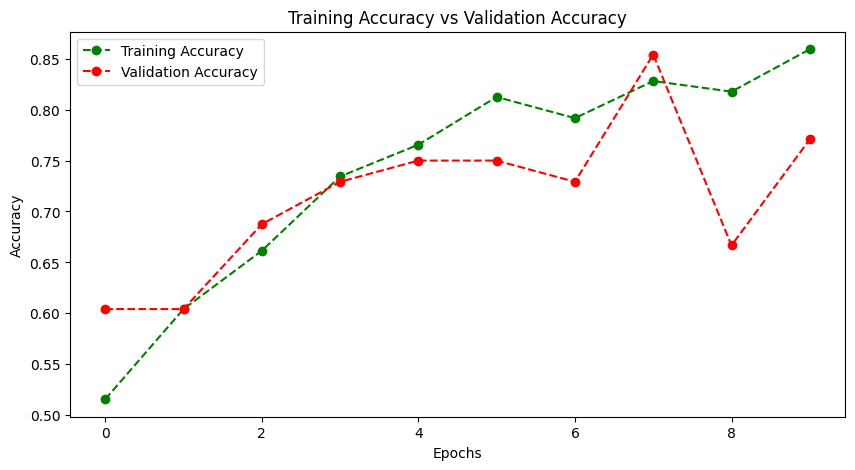

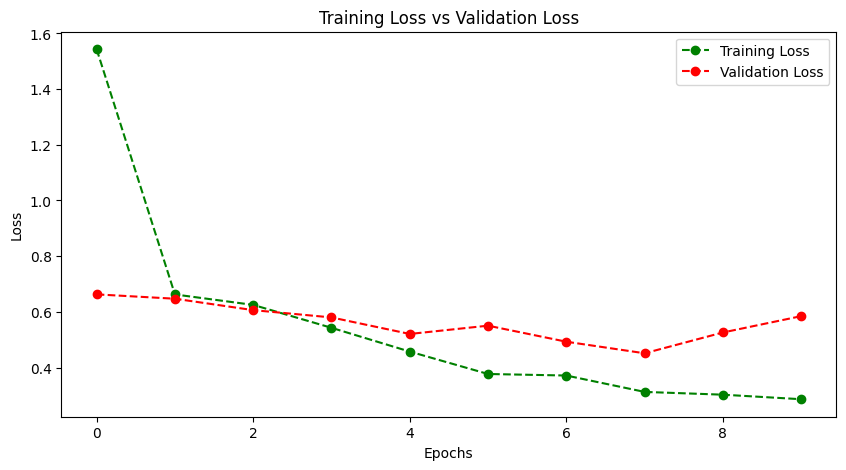

In [17]:
# Plot for accuracy vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], 'go--', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'ro--', label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'go--', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro--', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [18]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

2/2 [==============================] - 0s 125ms/step - loss: 0.5845 - accuracy: 0.7708
Validation Loss: 0.5845
Validation Accuracy: 0.7708


In [21]:
# Load the saved model
model = tf.keras.models.load_model('currency_classifier_with_edge_detection.h5')

# Load an image for prediction
img_path = './testing/fake/ss.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)
print(prediction)
# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The currency is predicted to be real.")
else:
    print("The currency is predicted to be fake.")


1/1 [==============================] - 0s 118ms/step
[[0.32449573]]
The currency is predicted to be fake.


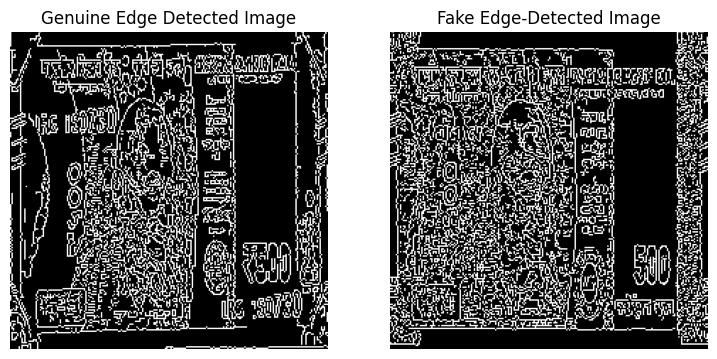

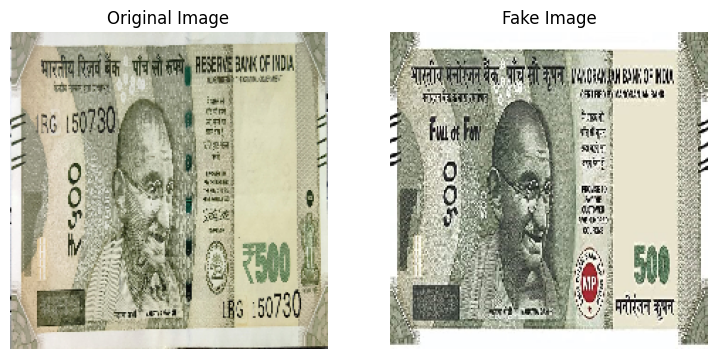

In [22]:
fake_img_path = './testing/fake/ss.jpg'
genuine_img_path = './tranning/real/500_s10.jpg'
# Load a fake image
fake_img = load_img(fake_img_path, target_size=(224, 224))
fake_img_array = img_to_array(fake_img) / 255.0

# Load a genuine image
genuine_img = load_img(genuine_img_path, target_size=(224, 224))
genuine_img_array = img_to_array(genuine_img) / 255.0

geunine_edge_detected_img = apply_edge_detection(genuine_img_array)
fake_edge_detected_img = apply_edge_detection(fake_img_array)

# Display the original and edge-detected image
plt.figure(figsize=(9,9))

plt.subplot(1, 2, 1)  # Removed extra arguments here
plt.imshow(geunine_edge_detected_img)
plt.title('Genuine Edge Detected Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_edge_detected_img)
plt.title('Fake Edge-Detected Image')
plt.axis('off')

plt.show()

# Display the original and edge-detected image
plt.figure(figsize=(9,9))

plt.subplot(1, 2, 1)  # Removed extra arguments here
plt.imshow(genuine_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_img)
plt.title('Fake Image')
plt.axis('off')

plt.show()


In [23]:
# Use the model.evaluate method
results = model.evaluate(X_val, y_val)

# 'results' will contain loss and accuracy
loss, accuracy = results

print(f'Validation Accuracy: {accuracy * 100:.2f}%')

2/2 [==============================] - 0s 91ms/step - loss: 0.5845 - accuracy: 0.7708
Validation Accuracy: 77.08%


In [26]:
# Load the saved model
model = tf.keras.models.load_model('currency_classifier_with_edge_detection.h5')

# Load an image for prediction
img_path = './tranning/real/500_s3.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)
print(prediction)
# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The currency is predicted to be real.")
else:
    print("The currency is predicted to be fake.")


1/1 [==============================] - 0s 93ms/step
[[0.3662513]]
The currency is predicted to be real.


In [27]:
# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)

# Convert predicted probabilities to binary predictions (0 or 1)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Generate a classification report for the validation set
report = classification_report(y_val, y_val_pred_binary)

# Print the classification report
print(report)

2/2 [==============================] - 0s 96ms/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        29
           1       1.00      0.42      0.59        19

    accuracy                           0.77        48
   macro avg       0.86      0.71      0.72        48
weighted avg       0.83      0.77      0.74        48

